In [1]:
import os

import sigpy as sp
import sigpy.plot as pl

import skimage.metrics

import numpy as np
import tensorflow as tf

from keras.models import Model, Input
from keras.optimizers import Adam

from keras.layers import Dense
from keras.layers import Conv3D, Conv3DTranspose
from keras.layers import Add, Concatenate
from keras.layers import Activation, LeakyReLU
from keras.layers import BatchNormalization, Lambda

from keras import backend as K

from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpus = [d for d in devices if d.name.lower().startswith('/device:gpu')]
print (f'using {len(gpus)} GPUs')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook

using 1 GPUs
Num GPUs Available:  1


In [2]:
import pydot

In [3]:
# define names
MODEL_NAME = '1'
DATASET = 'singlecoil_val'

# define paths
log_path = os.path.join('/central/groups/BEBi_205_Spring_2021/vliu/logs/val', f'model_{MODEL_NAME}.txt')
models_path = os.path.join('/central/groups/BEBi_205_Spring_2021/vliu', 'models')
npz_data_path = os.path.join('/central/groups/BEBi_205_Spring_2021/vliu/dataset_objects', f'{DATASET}.npz')

# define variables
in_shape_gen = (32, 256, 256, 2)
n_epoch = 1
trainable = False
models_path

'/central/groups/BEBi_205_Spring_2021/vliu/models'

In [4]:
def metricss(true_tensor, test_tensor):
    '''
    provides peak signal to ratio and structural similarity index
    base on 2D pictures of a single 3D MR image
    @params true_tensor: input shape (32, 256, 256)
    @params test_tensor: input shape (32, 256, 256)
    '''
    im_slices = true_tensor.shape[0]
    
    psnr_running = 0
    ssim_running = 0
    
    for i in range(im_slices):
        ssim = skimage.metrics.structural_similarity(true_tensor[i], test_tensor[i])
        psnr = skimage.metrics.peak_signal_noise_ratio(true_tensor[i], test_tensor[i])
        psnr_running += psnr
        ssim_running += ssim
        
    return psnr_running / im_slices, ssim / im_slices

In [5]:
def resden(
    x, fil_lay, fil_end, beta, 
    gamma_init, kernel_initz, trainable,
):   
    
    x1 = Conv3D(
        filters = fil_lay, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz,
        )(x)
    x1 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x1)
    x1 = LeakyReLU(alpha = 0.2)(x1)
    x1=Concatenate(axis=-1)([x, x1])
    
    
    x2 = Conv3D(
        filters = fil_lay, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz,
        )(x1)
    x2 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x2)
    x2 = LeakyReLU(alpha = 0.2)(x2)
    x2 = Concatenate(axis = -1)([x1, x2])
     
        
    x3 = Conv3D(
        filters = fil_lay, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz, 
        )(x2)
    x3 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x3)
    x3 = LeakyReLU(alpha = 0.2)(x3)
    x3 = Concatenate(axis = -1)([x2, x3])
    
    
    x4 = Conv3D(
        filters = fil_end, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz,
        )(x3)
    
    x4 = Lambda(lambda x: x * beta)(x4)
    
    xout = Add()([x4,x])
    return xout

def resresden(x, fil_lay, fil_end, beta, gamma_init, kernel_initz, trainable):
    
    x1 = resden(x,  fil_lay, fil_end, beta, gamma_init, kernel_initz, trainable,)
#     x2 = resden(x1, fil_lay, fil_end, beta, gamma_init, kernel_initz, trainable,)
    x3 = resden(x1, fil_lay, fil_end, beta, gamma_init, kernel_initz, trainable,)
    
    x3 = Lambda(lambda x : x * beta)(x3)
    
    xout = Add()([x3,x])
    return xout

In [23]:
# def generator(inp_shape, kernel_initz, trainable = True,):
#     gamma_init = tf.random_normal_initializer(1., 0.02)
    
#     fil_lay = 32
#     fil_end = 512
#     rrd_count = 12
#     beta = 0.2

    
#     inp_usamp_imag = Input(inp_shape) # (-1, 32, 256, 256, 2)
    
    
#     lay_1dn = Conv3D(
#         filters = 32, kernel_size = 4, strides = (1, 2, 2), # 32, 128, 128
#         padding = 'same', kernel_initializer = kernel_initz,
#         )(inp_usamp_imag)
#     lay_1dn = LeakyReLU(alpha = 0.2)(lay_1dn)

    
#     lay_2dn = Conv3D(
#         filters = 64, kernel_size = 4, strides = (1, 2, 2), # 32, 64, 64
#         padding = 'same', kernel_initializer = kernel_initz,
#         )(lay_1dn)
#     lay_2dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_2dn)
#     lay_2dn = LeakyReLU(alpha = 0.2)(lay_2dn)

    
#     lay_3dn = Conv3D(
#         filters = 128, kernel_size = 4, strides = (1, 2, 2), # 32, 32, 32
#         padding = 'same', kernel_initializer = kernel_initz,
#         )(lay_2dn)
#     lay_3dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_3dn)
#     lay_3dn = LeakyReLU(alpha = 0.2)(lay_3dn)

    
#     lay_4dn = Conv3D(
#         filters = 256, kernel_size = 4, strides = (2, 2, 2), # 16, 16, 16
#         padding = 'same', kernel_initializer = kernel_initz, 
#         )(lay_3dn)
#     lay_4dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_4dn)
#     lay_4dn = LeakyReLU(alpha = 0.2)(lay_4dn)  

    
#     lay_5dn = Conv3D(
#         filters = 256, kernel_size = 4, strides = (2, 2, 2), # 8, 8, 8
#         padding = 'same', kernel_initializer = kernel_initz,
#         )(lay_4dn)
#     lay_5dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_5dn)
#     lay_5dn = LeakyReLU(alpha = 0.2)(lay_5dn)


#     c1 = Conv3D(
#         filters = fil_end, kernel_size = 3, strides = 1,
#         padding = 'same', kernel_initializer = kernel_initz, 
#         )(lay_5dn)
    
#     xrrd = c1
#     for _ in range(rrd_count):
#         xrrd = resresden(xrrd, fil_lay, fil_end, beta, gamma_init, kernel_initz, trainable)

#     c2 = Conv3D(
#         filters = fil_end, kernel_size = 3, strides = 1,
#         padding = 'same', kernel_initializer = kernel_initz, 
#         )(xrrd)
    
    
#     lay_5upc = Add()([c1, c2]) # 8, 8, 8

    
#     lay_4up = Conv3DTranspose(
#         filters = 256, kernel_size = 4, strides = (2, 2, 2), # 16, 16, 16
#         padding = 'same', kernel_initializer = kernel_initz,
#         )(lay_5upc)
#     lay_4up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_4up)
#     lay_4up = Activation('relu')(lay_4up) 

#     lay_4upc = Concatenate(axis = -1)([lay_4up,lay_4dn]) 

    
    
#     lay_3up = Conv3DTranspose(
#         filters = 128, kernel_size = 4, strides = (2, 2, 2), # 32, 32, 32
#         padding = 'same', kernel_initializer = kernel_initz,
#         )(lay_4upc) 
#     lay_3up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_3up)
#     lay_3up = Activation('relu')(lay_3up)

#     lay_3upc = Concatenate(axis = -1)([lay_3up,lay_3dn])

    
#     lay_2up = Conv3DTranspose(
#         filters = 64, kernel_size = 4, strides = (1, 2, 2), #32, 64, 64
#         padding = 'same', kernel_initializer = kernel_initz,
#         )(lay_3upc)
#     lay_2up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_2up)
#     lay_2up = Activation('relu')(lay_2up)

#     lay_2upc = Concatenate(axis = -1)([lay_2up, lay_2dn])

    
#     lay_1up = Conv3DTranspose(
#         filters = 32, kernel_size = 4, strides = (1, 2, 2), #32, 128, 128
#         padding = 'same', kernel_initializer = kernel_initz,
#         )(lay_2upc)
#     lay_1up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_1up)
#     lay_1up = Activation('relu')(lay_1up) 

#     lay_1upc = Concatenate(axis = -1)([lay_1up,lay_1dn])

#     lay_256up = Conv3DTranspose(
#         filters = 32, kernel_size = 4, strides = (1, 2, 2), #32, 256, 256
#         padding = 'same', kernel_initializer = kernel_initz,
#         )(lay_1upc)
#     lay_256up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_256up)
#     lay_256up = Activation('relu')(lay_256up)

#     out = Conv3D(
#         filters = 1, kernel_size = 1, strides = (1, 1, 1), activation = 'tanh', 
#         padding = 'same', kernel_initializer = kernel_initz,
#         )(lay_256up)

#     model = Model(inputs = inp_usamp_imag, outputs = out)

#     return model



# contracted
def generator(inp_shape, kernel_initz, trainable = True):
    
    gamma_init = tf.random_normal_initializer(1., 0.02)
    fil_lay = 32
    fil_end = 64
    rrd_count = 6
    beta = 0.2

    
    inp_usamp_imag = Input(inp_shape) # (-1, 32, 256, 256, 2)
    
    
    lay_1dn = Conv3D(
        filters = 8, kernel_size = 4, strides = (2, 4, 4), # 16, 64, 64
        padding = 'same', kernel_initializer = kernel_initz,
        )(inp_usamp_imag)
    lay_1dn = LeakyReLU(alpha = 0.2)(lay_1dn)

    
    lay_2dn = Conv3D(
        filters = 16, kernel_size = 4, strides = (2, 2, 2), # 8, 32, 32
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_1dn)
    lay_2dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_2dn)
    lay_2dn = LeakyReLU(alpha = 0.2)(lay_2dn)

    
    lay_3dn = Conv3D(
        filters = 32, kernel_size = 4, strides = (1, 2, 2), # 8, 16, 16
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_2dn)
    lay_3dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_3dn)
    lay_3dn = LeakyReLU(alpha = 0.2)(lay_3dn)

    
    lay_4dn = Conv3D(
        filters = 64, kernel_size = 4, strides = (1, 2, 2), # 8, 8, 8
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_3dn)
    lay_4dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_4dn)
    lay_4dn = LeakyReLU(alpha = 0.2)(lay_4dn)


    c1 = Conv3D(
        filters = fil_end, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz, 
        )(lay_4dn)
    
    xrrd = c1
    for _ in range(rrd_count):
        xrrd = resresden(xrrd, fil_lay, fil_end, beta, gamma_init, kernel_initz, trainable)

    c2 = Conv3D(
        filters = fil_end, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz, 
        )(xrrd)
    
    
    lay_4upc = Add()([c1, c2]) # 8, 8, 8

    
    lay_3up = Conv3DTranspose(
        filters = 32, kernel_size = 4, strides = (1, 2, 2), # 8, 16, 16
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_4upc)
    lay_3up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_3up)
    lay_3up = Activation('relu')(lay_3up) 

    lay_3upc = Concatenate(axis = -1)([lay_3up,lay_3dn]) 

    
    
    lay_2up = Conv3DTranspose(
        filters = 16, kernel_size = 4, strides = (1, 2, 2), # 8, 32, 32
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_3upc) 
    lay_2up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_2up)
    lay_2up = Activation('relu')(lay_2up)

    lay_2upc = Concatenate(axis = -1)([lay_2up,lay_2dn])

    
    lay_1up = Conv3DTranspose(
        filters = 8, kernel_size = 4, strides = (2, 2, 2), # 16, 64, 64
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_2upc)
    lay_1up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_1up)
    lay_1up = Activation('relu')(lay_1up)

    lay_1upc = Concatenate(axis = -1)([lay_1up, lay_1dn])


    lay_256up = Conv3DTranspose(
        filters = 8, kernel_size = 4, strides = (2, 4, 4), #32, 256, 256
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_1upc)
    lay_256up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_256up)
    lay_256up = Activation('relu')(lay_256up)

    out = Conv3D(
        filters = 1, kernel_size = 1, strides = (1, 1, 1), activation = 'tanh', 
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_256up)

    model = Model(inputs = inp_usamp_imag, outputs = out)

    return model

In [29]:
# improved
def generator(inp_shape, kernel_initz, trainable = True,):
    gamma_init = tf.random_normal_initializer(1., 0.02)
    
    fil_lay = 64
    fil_end = 512 
    rrd_count = 6
    beta = 0.2

    
    inp_usamp_imag = Input(inp_shape) # (-1, 32, 256, 256, 2)
    
    
    lay_1dn = Conv3D(
        filters = 32 * 2, kernel_size = 4, strides = (1, 2, 2), # 32, 128, 128
        padding = 'same', kernel_initializer = kernel_initz,
        )(inp_usamp_imag)
    lay_1dn = LeakyReLU(alpha = 0.2)(lay_1dn)

    
    lay_2dn = Conv3D(
        filters = 64 * 2, kernel_size = 4, strides = (1, 2, 2), # 32, 64, 64
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_1dn)
    lay_2dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_2dn)
    lay_2dn = LeakyReLU(alpha = 0.2)(lay_2dn)

    
    lay_3dn = Conv3D(
        filters = 128 * 2, kernel_size = 4, strides = (1, 2, 2), # 32, 32, 32
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_2dn)
    lay_3dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_3dn)
    lay_3dn = LeakyReLU(alpha = 0.2)(lay_3dn)

    
    lay_4dn = Conv3D(
        filters = 256 * 2, kernel_size = 4, strides = (2, 2, 2), # 16, 16, 16
        padding = 'same', kernel_initializer = kernel_initz, 
        )(lay_3dn)
    lay_4dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_4dn)
    lay_4dn = LeakyReLU(alpha = 0.2)(lay_4dn)  

    
    lay_5dn = Conv3D(
        filters = 256 * 2, kernel_size = 4, strides = (2, 2, 2), # 8, 8, 8
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_4dn)
    lay_5dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_5dn)
    lay_5dn = LeakyReLU(alpha = 0.2)(lay_5dn)


    c1 = Conv3D(
        filters = fil_end, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz, 
        )(lay_5dn)
    
    xrrd = c1
    for _ in range(rrd_count):
        xrrd = resresden(xrrd, fil_lay, fil_end, beta, gamma_init, kernel_initz, trainable)

    c2 = Conv3D(
        filters = fil_end, kernel_size = 3, strides = 1,
        padding = 'same', kernel_initializer = kernel_initz, 
        )(xrrd)
    
    
    lay_5upc = Add()([c1, c2]) # 8, 8, 8

    
    lay_4up = Conv3DTranspose(
        filters = 256 * 2, kernel_size = 4, strides = (2, 2, 2), # 16, 16, 16
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_5upc)
    lay_4up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_4up)
    lay_4up = Activation('relu')(lay_4up) 

    lay_4upc = Concatenate(axis = -1)([lay_4up,lay_4dn]) 

    
    
    lay_3up = Conv3DTranspose(
        filters = 128 * 2, kernel_size = 4, strides = (2, 2, 2), # 32, 32, 32
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_4upc) 
    lay_3up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_3up)
    lay_3up = Activation('relu')(lay_3up)

    lay_3upc = Concatenate(axis = -1)([lay_3up,lay_3dn])

    
    lay_2up = Conv3DTranspose(
        filters = 64 * 2, kernel_size = 4, strides = (1, 2, 2), #32, 64, 64
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_3upc)
    lay_2up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_2up)
    lay_2up = Activation('relu')(lay_2up)

    lay_2upc = Concatenate(axis = -1)([lay_2up, lay_2dn])

    
    lay_1up = Conv3DTranspose(
        filters = 32 * 2, kernel_size = 4, strides = (1, 2, 2), #32, 128, 128
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_2upc)
    lay_1up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_1up)
    lay_1up = Activation('relu')(lay_1up) 

    lay_1upc = Concatenate(axis = -1)([lay_1up,lay_1dn])

    lay_256up = Conv3DTranspose(
        filters = 32, kernel_size = 4, strides = (1, 2, 2), #32, 256, 256
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_1upc)
    lay_256up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_256up)
    lay_256up = Activation('relu')(lay_256up)

    out = Conv3D(
        filters = 1, kernel_size = 1, strides = (1, 1, 1), activation = 'tanh', 
        padding = 'same', kernel_initializer = kernel_initz,
        )(lay_256up)

    model = Model(inputs = inp_usamp_imag, outputs = out)

    return model

In [7]:
# # load validation data
# npzfile = np.load(f'{npz_data_path}')
# usamp_all = npzfile['arr_0']
# real_all = npzfile['arr_1']

In [30]:
K.clear_session()
my_gen = generator(inp_shape = in_shape_gen, kernel_initz = 'glorot_uniform', trainable = False)

In [ ]:
f = open(log_path, 'w')
for i in range(n_epoch):
    f.write(f'> epoch {i + 1}:')
    print(f'> epoch {i + 1}')
    
    # get weights
    my_gen.load_weights(os.path.join(models_path, f'{MODEL_NAME}_epoch_3.h5'))
    
    psnrt = 0
    ssimt = 0
    # get metrics
    for j in range(len(usamp_all)):
        predicted = my_gen.predict(usamp_all[[j]])
        
        # set right sizes for metrics
        real = np.reshape(real_all[j], (32, 256, 256))
        real = real.astype('float32')
        predicted = np.reshape(predicted, (32, 256, 256))
        
        # record metrics
        psnr, ssim = metricss(real, predicted)
        
        psnrt += psnr
        ssimt += ssim
    
        
    f.write(f'    psnr = %.7f, ssim = %.7f \n\n' % (psnrt / len(usamp_all), ssimt / len(usamp_all)))
    print(f'    psnr = %.7f, ssim = %.7f \n\n' % (psnrt / len(usamp_all), ssimt / len(usamp_all)))

<IPython.core.display.Javascript object>


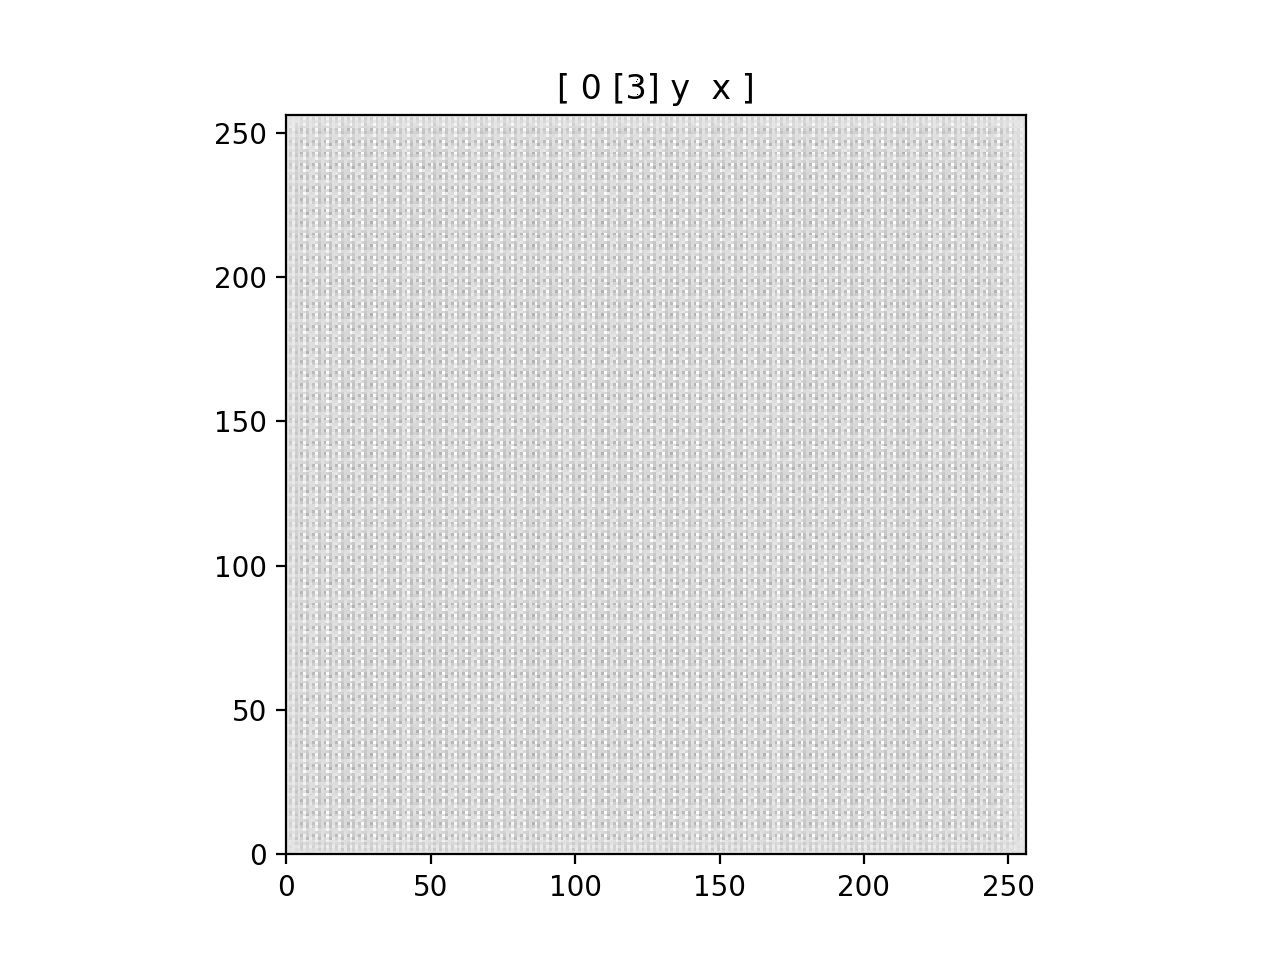

In [50]:
# get weights
my_gen.load_weights(os.path.join(models_path, f'{MODEL_NAME}_epoch_9.h5'))
usamp = usamp_all[[80]]
real = real_all[[80]]
predicted = my_gen.predict(usamp)
# pl.ImagePlot(usamp[:, :, :, :, 0]) #this is just real numbers. Don't use this in comparison
pl.ImagePlot(predicted[:, :, :, :, 0])
# pl.ImagePlot(real[:, :, :, :, 0])

In [44]:
# # get weights
# my_gen.load_weights(os.path.join('/home/vliu', f'{MODEL_NAME}_epoch_7.h5'))
# usamp = usamp_all[[80]]
# real = real_all[[80]]
# predicted = my_gen.predict(usamp)
# # pl.ImagePlot(usamp[:, :, :, :, 0]) #this is just real numbers. Don't use this in comparison
# pl.ImagePlot(predicted[:, :, :, :, 0])
# # pl.ImagePlot(real[:, :, :, :, 0])

In [61]:
dot_img_file = '/groups/BEBi_205_Spring_2021/vliu/figures/model_2.png'
tf.keras.utils.plot_model(my_gen, to_file=dot_img_file, show_shapes=True)